In [17]:
using PyPlot, ForwardDiff, TaylorSeries, LinearAlgebra
function rescale!(x::Taylor1,lambda)
    mult = one(lambda);
    for i in 2:length(x.coeffs)
        mult /= lambda
        x.coeffs[i] *= mult
    end
    x
end
ForwardDiff.can_dual(::Type{Taylor1{Float64}}) = true
Base.isinteger(::Taylor1{Float64}) = false

In [18]:
# function sol(x,y) 
# #     @assert 0<=x<1
#     xn, yn = 2x+0.25sinpi(2x)/2pi+0.02cospi(2y), 0.4y+0.4sinpi(2x)
#     isodd(floor(Int,xn)) && (yn *= -1)
#     mod(xn,1),yn
# end
# sol(x,y) = mod.((2x+y,x+y-0.05sinpi(2x+2y)),1
function sol(x,y)
    xn,yn = mod.((2x+y,x+y),1)
    contractionamt = -0.5+mod((1+sqrt(5))\2xn-yn,1)
    a = 4; b = 3
    yn += exp(-1/(a*xn*(1-xn)))*contractionamt*b
    xn,mod(yn,1)
end
sol(x) = [sol(x...)...]

function Jsol(x,y)
    Jcat = [2 1; 1 1]
    xn,yn = mod.((2x+y,x+y),1)
    contractionamt = -0.5+mod((1+sqrt(5))\2xn-yn,1); 
    d_contractionamt = [(1+sqrt(5))\2 -1]
    a = 2; b = 3
    expamt = exp(-1/(a*xn*(1-xn))); d_expamt = [expamt*(1-2xn)/(a*((1-xn)*xn)^2) 0]
    Jcat + [0 0; (d_contractionamt*expamt + d_expamt*contractionamt)]*b*Jcat
end


Jsol (generic function with 1 method)

In [19]:
t = Taylor1(Float64,2)
(xsol,ysol) = rand(2) .+ t
# vusol = randn(2)+dualnum*randn(2)
for i = 1:10000
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
#     vusol = Jsol([xsol,ysol])*vusol; vusol /= norm(realpart.(vusol)) # to make make sense....
#     println(vusol)
end
N = 200_000
solh = Array{typeof(xsol)}(undef,N,2)
# vusolh = Array{Dual{Float64}}(undef,N,2)
lusolh = Array{Float64}(undef,N)
for i = 1:N
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
    solh[i,1] = xsol; solh[i,2] = ysol
    lusolh[i] = lusol
end
dxdtnorm = hypot.(differentiate.(solh[:,1]),differentiate.(solh[:,2]))
rhograds = getindex.(1 ./dxdtnorm,1);

In [20]:
lsol = rand(2) .+ differentiate(t^2/2)
lsolh = Array{Taylor1{Float64}}(undef,N,2)
lsolh[N,:] = lsol
for i = N-1:-1:1
    lsol = Jsol(solh[i+1,1],solh[i+1,2])'*lsol; lsol /= dot(differentiate.(solh[i,:])/dxdtnorm[i],lsol)
    lsolh[i,:] = lsol
    end
lnorms = vec(mapslices(x->norm(getcoeff.(x,0)),lsolh,dims=2))
dldt = getcoeff.(lsolh,1);

In [21]:
krhopart = rhograds.*lsolh; krhonorms = rhograds .* lnorms
kXnorms = lnorms;
klpart = dldt ./ dxdtnorm; klnorms = vec(mapslices(norm,klpart,dims=2));

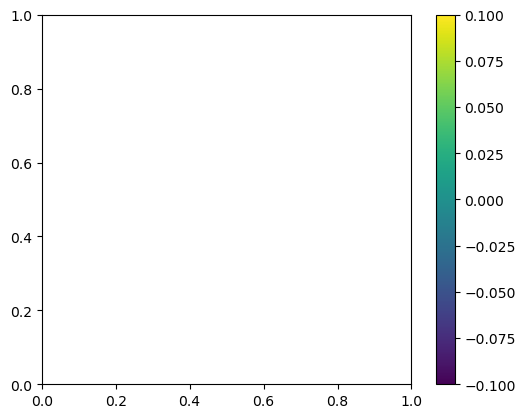

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6abc51d430>

In [22]:
scatter(map.(solh[:,1],0),map.(solh[:,2],0),c=krhonorms,marker=".",s=0.01)
gca().set_aspect("equal")
xlim(0,1);ylim(0,1); 
colorbar()

100000-element Array{Taylor1{Float64},1}:
     0.5612290782290489 + 𝒪(t¹)
      2.402920864653371 + 𝒪(t¹)
   - 1.9087406544046388 + 𝒪(t¹)
     1.0540270147803774 + 𝒪(t¹)
   - 0.4488086503368325 + 𝒪(t¹)
     0.8979471157356367 + 𝒪(t¹)
     0.2503576217857373 + 𝒪(t¹)
   - 0.6686606685012899 + 𝒪(t¹)
     0.9116605020477792 + 𝒪(t¹)
     0.6777600848694683 + 𝒪(t¹)
    0.15878225091811352 + 𝒪(t¹)
     0.3053840941951601 + 𝒪(t¹)
       1.18121511045889 + 𝒪(t¹)
                              ⋮
     0.3121104623603936 + 𝒪(t¹)
   - 0.6712617844768393 + 𝒪(t¹)
    - 1.002776647367204 + 𝒪(t¹)
   - 0.4091760069438069 + 𝒪(t¹)
  - 0.37239308383411984 + 𝒪(t¹)
      0.726788929954354 + 𝒪(t¹)
      2.172587794311999 + 𝒪(t¹)
       0.70108257525509 + 𝒪(t¹)
  - 0.23387417896466584 + 𝒪(t¹)
     0.6598864052856839 + 𝒪(t¹)
     2.5197203532697534 + 𝒪(t¹)
     0.8594658507920063 + 𝒪(t¹)

In [41]:
differentiate.(solh)

100000×2 Array{Taylor1{Float64},2}:
   0.9839312707454116 + 0.03286479836772732 t + 𝒪(t²)  …    0.17854762515732162 - 3.3244115150050115 t + 𝒪(t²)
    0.8438816703051599 - 0.5037089237815681 t + 𝒪(t²)        0.5365293342613929 - 3.6863783774800534 t + 𝒪(t²)
   0.6896329752034569 - 0.45120760070564364 t + 𝒪(t²)        0.7241590705860337 + 3.0654981545935756 t + 𝒪(t²)
     0.7677452994278289 + 0.288173098118337 t + 𝒪(t²)         0.640755144502542 - 1.9902619077250743 t + 𝒪(t²)
     0.86791556768346 - 0.22488609729813114 t + 𝒪(t²)       0.49671175481630925 + 1.2965080630628811 t + 𝒪(t²)
    0.621443402455453 + 0.06560719929971506 t + 𝒪(t²)  …      0.783459059265122 - 1.1981714497941154 t + 𝒪(t²)
   0.8218033557520629 - 0.17549130756951575 t + 𝒪(t²)        0.5697712211709614 - 0.1862822697532222 t + 𝒪(t²)
   0.5585281768066004 - 0.03421113477299349 t + 𝒪(t²)        0.8294855488271601 + 0.8291507334937855 t + 𝒪(t²)
   0.9445358255006804 + 0.17911791381647216 t + 𝒪(t²)         0.328408395668